In [1]:
from __future__ import print_function
from __future__ import division
from __future__ import absolute_import

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

tf.set_random_seed(2017)

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


从`logistic_regression_data.txt`中读取数据

文件的每一行由三个元素构成, `x`坐标, `y`坐标, 对应`label`

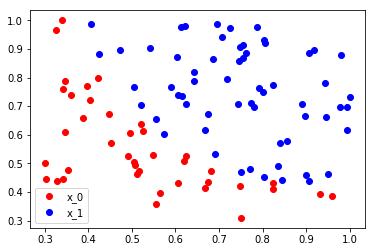

In [2]:
%matplotlib inline

# 从 data.txt 中读入点
with open('./data/logistic_regression.txt', 'r') as f:
    data_list = [i.split('\n')[0].split(',') for i in f.readlines()]
    data = [(float(i[0]), float(i[1]), float(i[2])) for i in data_list]

# 标准化
x0_max = max([i[0] for i in data])
x1_max = max([i[1] for i in data])
data = [(i[0]/x0_max, i[1]/x1_max, i[2]) for i in data]

x0 = list(filter(lambda x: x[-1] == 0.0, data)) # 选择第一类的点
x1 = list(filter(lambda x: x[-1] == 1.0, data)) # 选择第二类的点

plot_x0 = [i[0] for i in x0]
plot_y0 = [i[1] for i in x0]
plot_x1 = [i[0] for i in x1]
plot_y1 = [i[1] for i in x1]

plt.plot(plot_x0, plot_y0, 'ro', label='x_0')
plt.plot(plot_x1, plot_y1, 'bo', label='x_1')
plt.legend(loc='best')

In [3]:
np_data = np.array(data, dtype='float32') # 转换成 numpy array
x_data = tf.constant(np_data[:, 0:2], name='x') # 转换成 Tensor, 大小是 [100, 2]
y_data = tf.expand_dims(tf.constant(np_data[:, -1]), axis=-1) # 转换成 Tensor，大小是 [100, 1]

构建模型

In [4]:
w = tf.get_variable(initializer=tf.random_normal_initializer(seed=2017), shape=(2, 1), name='weights')
b = tf.get_variable(initializer=tf.zeros_initializer(), shape=(1), name='bias')

def logistic_regression(x):
    # 使用 tf.sigmoid 将结果映射到 [0, 1] 区间
    return tf.sigmoid(tf.matmul(x, w) + b)

In [5]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

画出模型随机初始化的分类效果

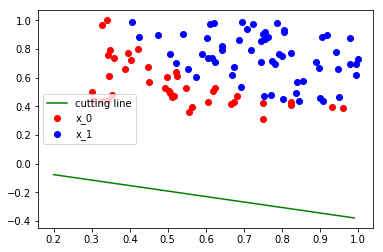

In [6]:
%matplotlib inline

# 画出初始分类效果
w_numpy = w.eval(session=sess)
b_numpy = b.eval(session=sess)

w0 = w_numpy[0]
w1 = w_numpy[1]
b0 = b_numpy[0]

plot_x = np.arange(0.2, 1, 0.01)
plot_y = (-w0 * plot_x - b0) / w1

plt.plot(plot_x, plot_y, 'g', label='cutting line')
plt.plot(plot_x0, plot_y0, 'ro', label='x_0')
plt.plot(plot_x1, plot_y1, 'bo', label='x_1')
plt.legend(loc='best')

### 优化模型
- 损失函数

$$
loss = -(y log(\hat{y}) + (1 - y) log(1 - \hat{y}))
$$


In [8]:
def binary_loss(y_pred, y):
    logit = tf.reduce_mean(y * tf.log(y_pred) + (1 - y) * tf.log(1 - y_pred))
    return -logit

y_pred = logistic_regression(x_data)
loss = binary_loss(y_pred, y_data)

print(loss.eval(session=sess))

0.7408897


我们继续用梯度下降法来进行模型优化

In [9]:
# 梯度计算以及参数更新
w_grad, b_grad = tf.gradients(loss, [w, b])

lr = 0.1

w_update = w.assign_sub(lr * w_grad)
b_update = b.assign_sub(lr * b_grad)

# 更新一次参数
sess.run([w_update, b_update])

# 查看更新后的`loss`
print(loss.eval(session=sess))

0.7321346


In [10]:
# 首先从tf.train中定义一个优化方法
optimizer = tf.train.GradientDescentOptimizer(learning_rate=1, name='optimizer')

# 利用这个优化方法去优化一个损失函数, 得到的这个`op`就是我们想要的
train_op = optimizer.minimize(loss)

现在我们得到了一个`train_op`, 它实际上等价于上面更新模型的所有操作, 也就是说`train_op = 计算梯度 + 参数更新`, 我们来看一下它的效果吧

In [11]:
import time

sess.run(tf.global_variables_initializer())

# 这一行用于时间统计，不重要
start = time.time()
for e in range(1000):
    sess.run(train_op)
    
    if (e + 1) % 200 == 0:
        # 计算正确率
        y_true_label = y_data.eval(session=sess)
        y_pred_numpy = y_pred.eval(session=sess)
        y_pred_label = np.greater_equal(y_pred_numpy, 0.5).astype(np.float32)
        accuracy = np.mean(y_pred_label == y_true_label)
        loss_numpy = loss.eval(session=sess)
        print('Epoch %d, Loss: %.4f, Acc: %.4f' % (e + 1, loss_numpy, accuracy))
    
print()
print('manual_GD cost time: %.4f' % (time.time() - start))

Epoch 200, Loss: 0.4091, Acc: 0.9100
Epoch 400, Loss: 0.3296, Acc: 0.9200
Epoch 600, Loss: 0.2934, Acc: 0.9100
Epoch 800, Loss: 0.2725, Acc: 0.9100
Epoch 1000, Loss: 0.2588, Acc: 0.9000

manual_GD cost time: 0.5839


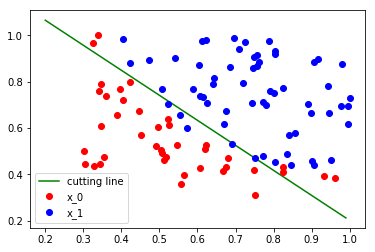

In [12]:
%matplotlib inline

# 画出最终分类效果
w_numpy = w.eval(session=sess)
b_numpy = b.eval(session=sess)

w0 = w_numpy[0]
w1 = w_numpy[1]
b0 = b_numpy[0]

plot_x = np.arange(0.2, 1, 0.01)
plot_y = (-w0 * plot_x - b0) / w1

plt.plot(plot_x, plot_y, 'g', label='cutting line')
plt.plot(plot_x0, plot_y0, 'ro', label='x_0')
plt.plot(plot_x1, plot_y1, 'bo', label='x_1')
plt.legend(loc='best')

In [13]:
loss1 = tf.losses.log_loss(predictions=y_pred, labels=y_data)
optimizer1 = tf.train.GradientDescentOptimizer(learning_rate=lr)
train_op1 = optimizer1.minimize(loss1)

In [14]:
sess.run(tf.global_variables_initializer())

start = time.time()
for e in range(1000):
    sess.run(train_op1)
    
    if (e + 1) % 200 == 0:
        # 计算正确率
        y_true_label = y_data.eval(session=sess)
        y_pred_numpy = y_pred.eval(session=sess)
        y_pred_label = np.greater_equal(y_pred_numpy, 0.5).astype(np.float32)
        accuracy = np.mean(y_pred_label == y_true_label)
        loss_numpy = loss.eval(session=sess)
        print('Epoch %d, Loss: %.4f, Acc: %.4f' % (e + 1, loss_numpy, accuracy))

print()
print('Tensorflow_GD cost time: %.4f' % (time.time() - start))

Epoch 200, Loss: 0.6286, Acc: 0.6000
Epoch 400, Loss: 0.5843, Acc: 0.6000
Epoch 600, Loss: 0.5474, Acc: 0.6700
Epoch 800, Loss: 0.5164, Acc: 0.7600
Epoch 1000, Loss: 0.4902, Acc: 0.7900

Tensorflow_GD cost time: 0.7588
